### import necessary modules


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import subprocess
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from PIL import Image
import zipfile
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### method 3 extraction

In [5]:
# Function to extract a ZIP file
def extract_zip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Function to move extracted data to a writable directory
def move_to_writable_directory(source_path, destination_path):
    shutil.move(source_path, destination_path)

# Function to chunk data into smaller batches
def chunk_data(X, y, batch_size):
    num_samples = len(X)
    num_batches = num_samples // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_X = X[start_idx:end_idx]
        batch_y = y[start_idx:end_idx]

        yield batch_X, batch_y

    # Handle the last batch, which may have fewer samples
    if num_samples % batch_size != 0:
        start_idx = num_batches * batch_size
        batch_X = X[start_idx:]
        batch_y = y[start_idx:]

        yield batch_X, batch_y

# Create a writable directory for extraction
extract_path_train = "/content/extracted_data_train"
if not os.path.exists(extract_path_train):
    os.makedirs(extract_path_train)

train_dir = "/content/drive/MyDrive/Image_Event/Train"
test_dir = "/content/drive/MyDrive/Image_Event/Test"
categories = ["Cards", "Center", "Corner", "Free-Kick", "Left", "Penalty", "Red-Cards", "Right", "Tackle", "Yellow-Cards"]

train_data = []
train_labels = []

# Extract and process training data with a subset of images per category
subset_size_per_category = 1500  # Adjust as needed

for category in categories:
    zip_file_path = os.path.join(train_dir, f"{category}.zip")

    try:
        extract_zip(zip_file_path, extract_path_train)
    except Exception as e:
        print(f"Error extracting {zip_file_path}: {e}")

    category_path = os.path.join(extract_path_train, category)

    if os.path.exists(category_path):
        print(f"Listing files in directory for category {category}: {os.listdir(category_path)}")

        # Counter for tracking the number of images processed for each category
        image_count = 0

        for img_file in os.listdir(category_path):
            if image_count < subset_size_per_category:
                img_path = os.path.join(category_path, img_file)
                img = Image.open(img_path).convert("RGB").resize((224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                train_data.append(img_array)
                train_labels.append(categories.index(category))

                image_count += 1
            else:
                break  # Stop processing images for this category once the subset size is reached
    else:
        print(f"Warning: Directory not found for category {category}")

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data,
                                                  train_labels,
                                                  test_size=0.2,
                                                  random_state=42)

# Convert your training data to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_train), np.array(y_train)))


def preprocess_image(image, label):
    # Resize and reshape the image to the desired dimensions
    image = tf.image.resize_with_pad(image, 150, 150)
    # Perform any additional preprocessing if needed
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply preprocessing to the training dataset
train_dataset = train_dataset.map(preprocess_image)

# Create ImageDataGenerator for training data
batch_size_train = 16
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Flow training images in batches using the training generator
train_generator = train_datagen.flow(np.array(X_train), np.array(y_train), batch_size=batch_size_train)


# Define batch size for validation data
batch_size_val = 16

# Create ImageDataGenerator for validation data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


# Flow validation images in batches using the validation generator
val_generator = val_datagen.flow(np.array(X_val), np.array(y_val), batch_size=batch_size_val)


# Define batch size for validation data
batch_size_val = 16

# Create a writable directory for extraction
extract_path_test = "/content/extracted_data_test"
if not os.path.exists(extract_path_test):
    os.makedirs(extract_path_test)

test_data = []
test_labels = []

# Extract and process test data with a subset of images per category
subset_size_per_category = 500  # Adjust as needed

for category in categories:
    zip_file_path = os.path.join(test_dir, f"{category}.zip")

    try:
        extract_zip(zip_file_path, extract_path_test)
    except Exception as e:
        print(f"Error extracting {zip_file_path}: {e}")

    category_path = os.path.join(extract_path_test, category)

    # Counter for tracking the number of images processed for each category
    image_count = 0

    for img_file in os.listdir(category_path):
        if image_count < subset_size_per_category:
            img_path = os.path.join(category_path, img_file)
            img = Image.open(img_path).convert("RGB").resize((224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            test_data.append(img_array)
            test_labels.append(categories.index(category))

            image_count += 1
        else:
            break  # Stop processing images for this category once the subset size is reached

# Convert your test data to TensorFlow Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((np.array(test_data), np.array(test_labels)))

# Apply preprocessing to the test dataset
test_dataset = test_dataset.map(preprocess_image)

# Define batch size for test data
batch_size_test = 16

# Create ImageDataGenerator for test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255
                                                               )

# Flow test images in batches using the test generator
test_generator = val_datagen.flow(np.array(test_data), np.array(test_labels), batch_size=batch_size_test)



### Data Viz

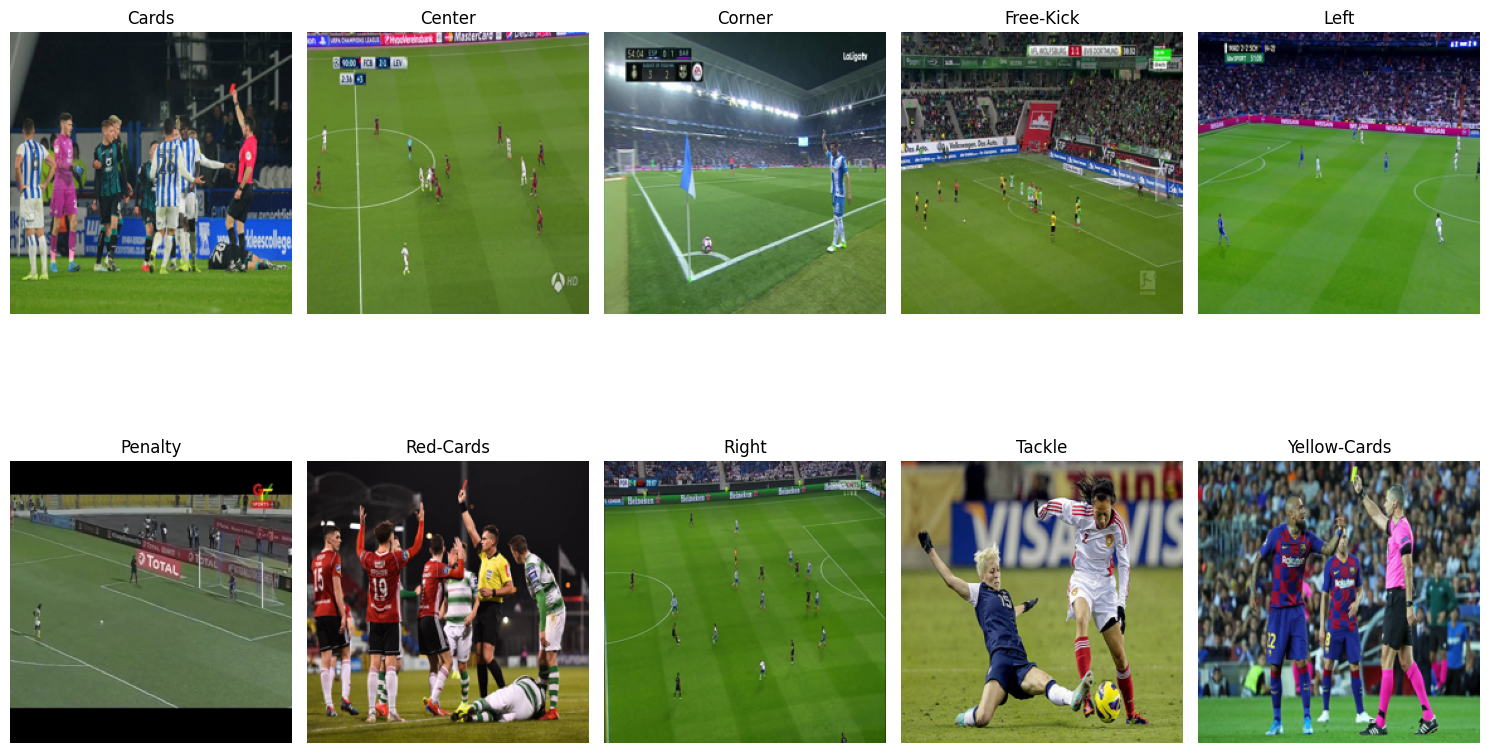

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 10))


def get_sample_image(category_data):
    return category_data[0]


for i, category in enumerate(categories):
    category_images = [img for img, label in zip(X_train, y_train) if label == i]
    sample_image = get_sample_image(category_images)


    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_image / 255.0)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Model

In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

num_classes = len(categories)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])


model.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [9]:
from tensorflow.keras.utils import to_categorical


y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)


history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/10
750/750 [==============================] - 144s 176ms/step - loss: 1.7981 - accuracy: 0.2691 - val_loss: 1.4511 - val_accuracy: 0.4123
Epoch 2/10
750/750 [==============================] - 128s 171ms/step - loss: 1.4867 - accuracy: 0.3868 - val_loss: 1.0782 - val_accuracy: 0.5610
Epoch 3/10
750/750 [==============================] - 130s 174ms/step - loss: 1.2596 - accuracy: 0.4843 - val_loss: 0.9894 - val_accuracy: 0.5840
Epoch 4/10
750/750 [==============================] - 130s 174ms/step - loss: 1.1160 - accuracy: 0.5413 - val_loss: 0.8468 - val_accuracy: 0.6403
Epoch 5/10
750/750 [==============================] - 131s 175ms/step - loss: 1.0605 - accuracy: 0.5633 - val_loss: 0.7961 - val_accuracy: 0.6633
Epoch 6/10
750/750 [==============================] - 132s 175ms/step - loss: 1.0331 - accuracy: 0.5767 - val_loss: 0.8422 - val_accuracy: 0.6287
Epoch 7/10
750/750 [==============================] - 132s 176ms/step - loss: 1.0359 - accuracy: 0.5827 - val_loss: 0.8075 -

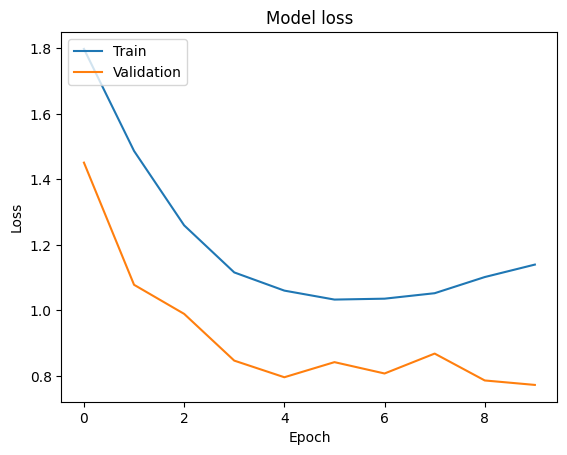

In [10]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

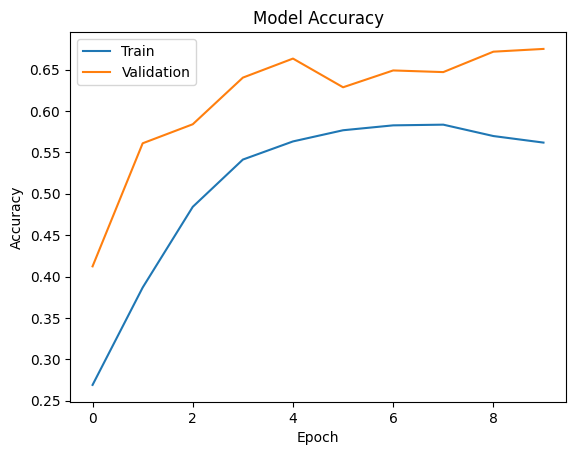

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

313/313 [==============================] - 4s 11ms/step
Accuracy: 0.102
F1 Score: 0.0926883945206342
Recall Score: 0.102


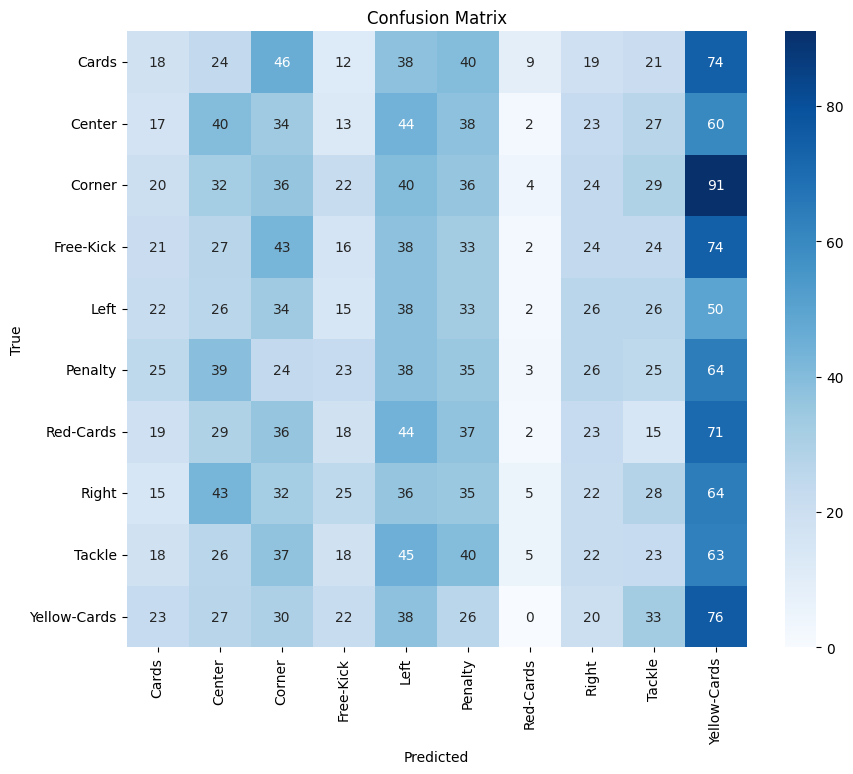

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score


predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)[:len(y_val)]


true_labels = np.array(y_val)
true_labels = np.argmax(true_labels, axis=1) if len(true_labels.shape) > 1 else true_labels


conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall Score: {recall}")


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### second model

In [13]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

num_classes = len(categories)

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')  # Adjust the number of units based on the number of categories
])

# Compile the model
model.compile(optimizer='RMSprop', # RMSprop, SGD, adam
              loss='sparse_categorical_crossentropy',  # Adjust the loss function based on your problem
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 128)      

In [14]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/10
750/750 [==============================] - 134s 176ms/step - loss: 1.7787 - accuracy: 0.2789 - val_loss: 1.6242 - val_accuracy: 0.3180
Epoch 2/10
750/750 [==============================] - 132s 176ms/step - loss: 1.4330 - accuracy: 0.4094 - val_loss: 1.1169 - val_accuracy: 0.5443
Epoch 3/10
750/750 [==============================] - 131s 175ms/step - loss: 1.2347 - accuracy: 0.4995 - val_loss: 0.8791 - val_accuracy: 0.6210
Epoch 4/10
750/750 [==============================] - 132s 176ms/step - loss: 1.1372 - accuracy: 0.5334 - val_loss: 0.8896 - val_accuracy: 0.6113
Epoch 5/10
750/750 [==============================] - 131s 175ms/step - loss: 1.0602 - accuracy: 0.5655 - val_loss: 0.8793 - val_accuracy: 0.6173
Epoch 6/10
750/750 [==============================] - 133s 177ms/step - loss: 1.0534 - accuracy: 0.5722 - val_loss: 1.3750 - val_accuracy: 0.5203
Epoch 7/10
750/750 [==============================] - 130s 173ms/step - loss: 1.0546 - accuracy: 0.5897 - val_loss: 0.9290 -

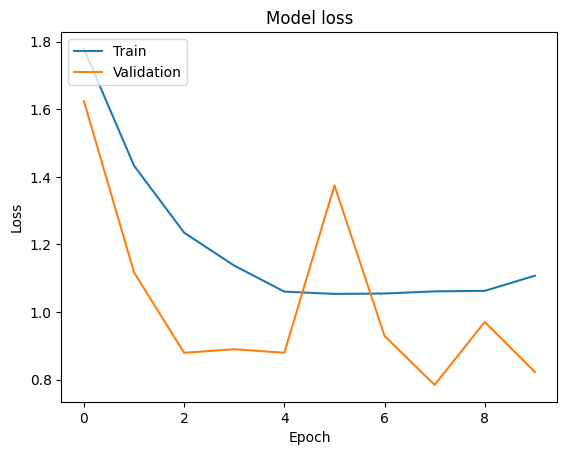

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

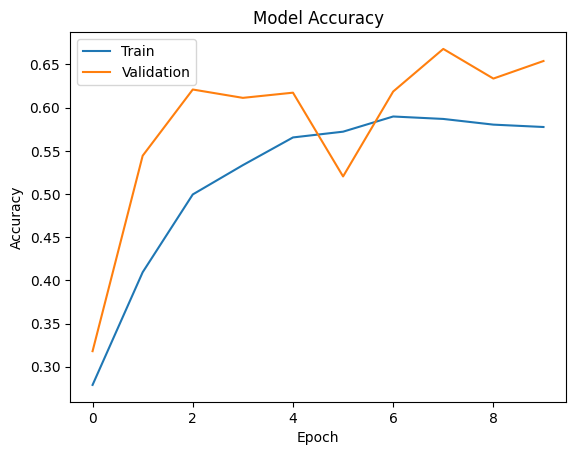

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

313/313 [==============================] - 3s 9ms/step
Accuracy: 0.101
F1 Score: 0.09137449545905611
Recall Score: 0.101


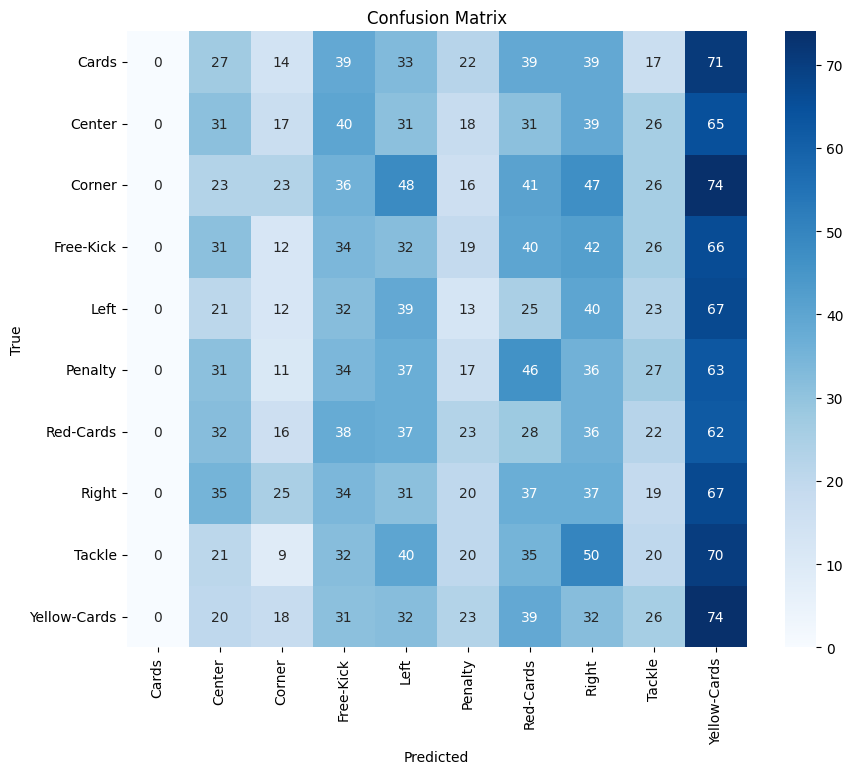

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)[:len(y_val)]


true_labels = np.array(y_val)
true_labels = np.argmax(true_labels, axis=1) if len(true_labels.shape) > 1 else true_labels


conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall Score: {recall}")


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### third model

In [18]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

num_classes = len(categories)


model_3 = models.Sequential([
    layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])



model_3.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 111, 111, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 55, 55, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 12, 12, 128)      

In [19]:
from tensorflow.keras.utils import to_categorical


y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)


history = model_3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/30
750/750 [==============================] - 127s 166ms/step - loss: 1.6444 - accuracy: 0.3327 - val_loss: 1.3850 - val_accuracy: 0.4080
Epoch 2/30
750/750 [==============================] - 126s 168ms/step - loss: 1.3935 - accuracy: 0.4199 - val_loss: 1.2655 - val_accuracy: 0.4607
Epoch 3/30
750/750 [==============================] - 126s 169ms/step - loss: 1.2775 - accuracy: 0.4701 - val_loss: 1.1389 - val_accuracy: 0.5123
Epoch 4/30
750/750 [==============================] - 127s 169ms/step - loss: 1.1850 - accuracy: 0.5089 - val_loss: 0.9672 - val_accuracy: 0.6023
Epoch 5/30
750/750 [==============================] - 127s 169ms/step - loss: 1.0876 - accuracy: 0.5461 - val_loss: 0.9049 - val_accuracy: 0.6223
Epoch 6/30
750/750 [==============================] - 126s 168ms/step - loss: 1.0354 - accuracy: 0.5704 - val_loss: 0.8689 - val_accuracy: 0.6303
Epoch 7/30
750/750 [==============================] - 126s 168ms/step - loss: 0.9754 - accuracy: 0.5944 - val_loss: 0.8180 -

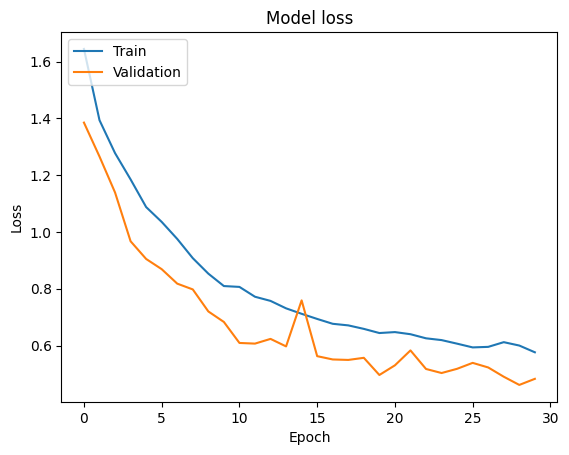

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

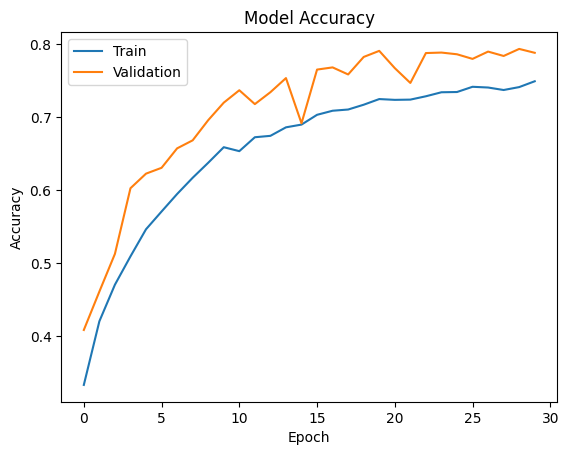

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

313/313 [==============================] - 3s 8ms/step
Accuracy: 0.09833333333333333
F1 Score: 0.08618700023753216
Recall Score: 0.09833333333333333


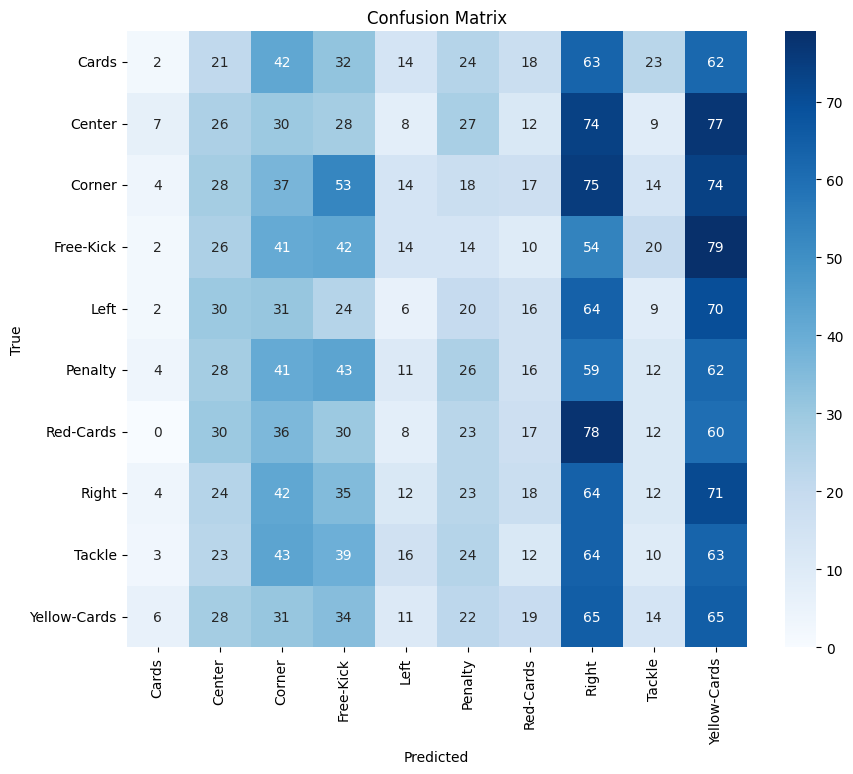

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
predictions = model_3.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)[:len(y_val)]

# Convert one-hot encoded labels to integers if needed
true_labels = np.array(y_val)
true_labels = np.argmax(true_labels, axis=1) if len(true_labels.shape) > 1 else true_labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall Score: {recall}")

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()